# Classification (sentiment)

This script is a demonstration of how to classify free text survey responses
according to pre-defined categories - in this case positive/neutral/negative
sentiment. The script takes a csv of survey data - one row per participant - and
asks a large language model (LLM) to classify each response one-by-one,
zero-shot without any training.


In [3]:
import pandas as pd
import lib
from tqdm import tqdm 
import matplotlib.pyplot as plt
tqdm.pandas()

input_datapath = "./data/gambling_feedback_data.csv"
index_col=None
text_col = "feedback"
survey_question_full = 'Do you have any other feedback on the design of the gambling management tool?'
category_options = ['Positive sentiment', 'Negative sentiment', 'Neutral sentiment']


The variables above can be customised to do any classification on any CSV
containing free text survey responses. For example you could change the
categories to
`category_options = ['Mentions potholes', 'Does not mention potholes']`

The file [lib.py](./lib.py) contains a method which constructs a prompt for the
LLM to classify a particular survey response. Let's see what the prompt looks
like with an example question & answer:


In [23]:
prompt, labels = lib.get_classification_prompt('Why is the sky blue?', "Because it's a beautiful day today", category_options)
print(prompt)

Here is a survey question, and an answer from one of the participants:

Q: Why is the sky blue?
A: Because it's a beautiful day today

Please classify the answer as one of the following options:

A. Positive sentiment
B. Negative sentiment
C. Neutral sentiment

Respond directly with the label and nothing else e.g. "A"


> Note to consider: does `e.g. "A"` at the end of the prompt bias the AI towards
> the first option?


## Load the data


In [24]:
df = pd.read_csv(input_datapath, index_col=index_col)
# df = df[headers]

df = df.dropna()
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

print(df.shape)
df.head()

(2164, 4)


/var/folders/4c/5kctcgk55539047v8xy3clj80000gn/T/ipykernel_4443/3445066923.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


,feedback,treatment,limit_on,block_on
0,good,4,0,0
1,no it was helpful,4,0,0
2,"was easy to see, and use the app.",3,0,1
3,i found it brilluant im nit a huge gamalaer bu...,2,0,0
4,is it not too easy for a person with a gamblin...,2,0,0


## Classify every response

This could take the best part of an hour for 2000 responses. Your OpenAI account
may need to be active for a certain number of days, and have spent a certain
amount of money for this to work.


In [5]:

df['category_index'] = df[text_col].progress_apply(lambda x: lib.classify_answer(survey_question_full, x, category_options))

df.to_csv(f"{'/'.join([x for x in input_datapath.split('.')[:-1] if x != ''])}_with_categories.csv")

df.head()[[text_col, 'category_index']]

  0%|          | 0/2164 [00:00<?, ?it/s]

100%|██████████| 2164/2164 [50:53<00:00,  1.41s/it]   


,feedback,category_index
0,good,0
1,no it was helpful,0
2,"was easy to see, and use the app.",0
3,i found it brilluant im nit a huge gamalaer bu...,0
4,is it not too easy for a person with a gamblin...,1


## Show examples from each category


In [19]:
for i in range(len(category_options)):
    print(f"Category: {category_options[i]}\n")
    print(lib.get_answers_string(df[df['category_index'] == i][text_col].sample(5).values))
    print("\n")

Category: Positive sentiment

- "was easy to use"
- "none seems easy"
- "its an easy app to use"
- "it seems intuitive to use"
- "i think it’s a good idea for people who need to set a limit on how much they spend"


Category: Negative sentiment

- "a bit confusing…should say…do you want to set a gambling limit…..yes/no…press yes go to another page….set limit….it will ask you to confirm the amount"
- "less wordy as it looks like a terms and conditions page"
 otherwise, i thought the page was very good."the button. i was unsure if the button was working or if it wasn't necessary for the survey. 
- "too much text on one screen - perhaps split up the functionality"
- "wouldn’t use"


Category: Neutral sentiment

- "maybe a big helpline number"
- "think it's good but would an addict use it"
- "just make it clear you have to click to set the limit not just enter the amount"
- "the gambling block button could be a bit brighter/bolder/bigger to make it stand out a bit more"
- "not sure"




## Plot the results


In [15]:
def plot_categories(treatment, num_samples):
    labels = category_options
    counts = df[df['treatment'] == treatment]['category_index'].value_counts()
    fig, ax = plt.subplots()
    ax.pie(counts.values, labels=[labels[i] for i in counts.index], autopct='%1.1f%%')
    ax.set_title(f"Treatment {treatment} ({num_samples} samples)")
    plt.show()


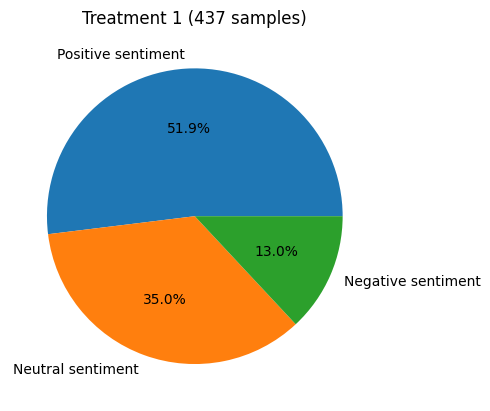

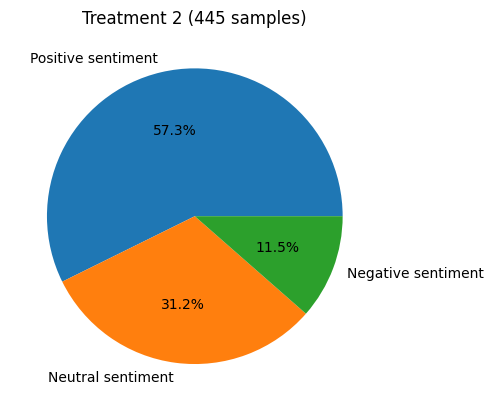

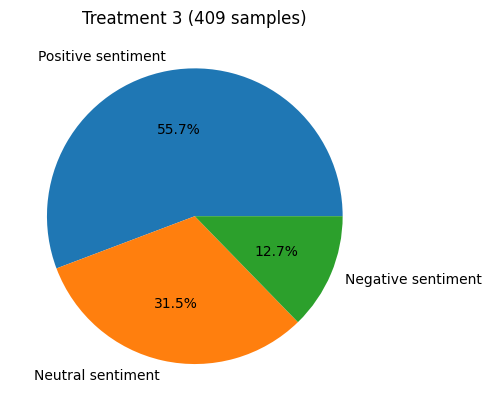

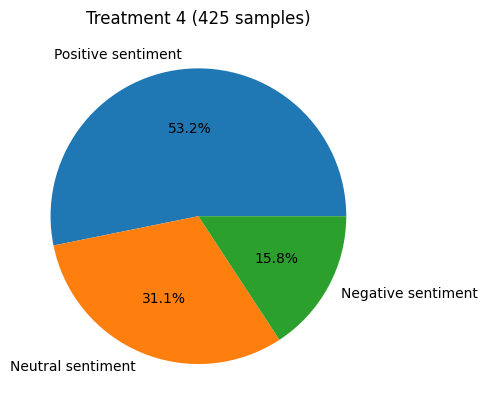

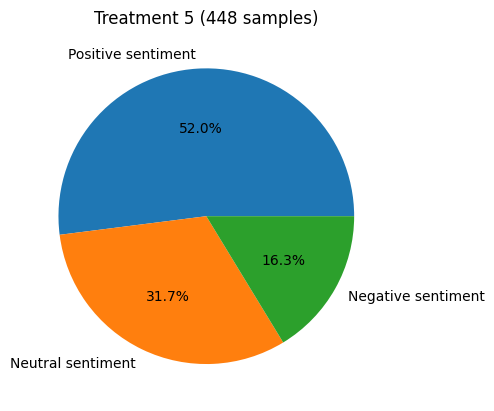

In [16]:
num_samples_by_treatment = df['treatment'].value_counts()
min_treatment = df['treatment'].min()
max_treatment = df['treatment'].max()

for treatment in range(min_treatment, max_treatment+1):
    plot_categories(treatment, num_samples_by_treatment[treatment])